In [1]:
using CSV, DataFrames
using LinearAlgebra
using PyPlot
using Test
using Printf
using Statistics
using Combinatorics
using Colors

In [2]:
#Have an GUI plot window pop up
pygui(false)

false

In [3]:
#Read in MOFs

_df_henry = CSV.read("../data/henry_constants_16Nov.csv")
for (i, xtal) in enumerate(_df_henry[:crystal])
    # Check replace() out for string replacement
    _df_henry[i, :crystal] = split(split(_df_henry[i, :crystal], ".cif")[1], "_")[1]
end
dropmissing!(_df_henry)
global const df_henry = deepcopy(_df_henry)

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_err henry coefficient [mmol/(g-bar)],CO2_Qst (kJ/mol),C2H6_henry coefficient [mmol/(g-bar)],C2H6_err henry coefficient [mmol/(g-bar)],C2H6_Qst (kJ/mol),CH4_henry coefficient [mmol/(g-bar)],CH4_err henry coefficient [mmol/(g-bar)],CH4_Qst (kJ/mol),H2S_henry coefficient [mmol/(g-bar)],H2S_err henry coefficient [mmol/(g-bar)],H2S_Qst (kJ/mol),H2O_TIP5P_henry coefficient [mmol/(g-bar)],H2O_TIP5P_err henry coefficient [mmol/(g-bar)],H2O_TIP5P_Qst (kJ/mol),o_xylene_henry coefficient [mmol/(g-bar)],o_xylene_err henry coefficient [mmol/(g-bar)],o_xylene_Qst (kJ/mol),m_xylene_henry coefficient [mmol/(g-bar)],m_xylene_err henry coefficient [mmol/(g-bar)],m_xylene_Qst (kJ/mol),p_xylene_henry coefficient [mmol/(g-bar)],p_xylene_err henry coefficient [mmol/(g-bar)],p_xylene_Qst (kJ/mol)
,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,BEDYEQ,4.93266,0.098177,25.7973,5.98116,0.0431582,22.2832,0.773284,0.00170916,13.7395,12.068,0.495953,28.084,189545.0,1.07118e5,67.2336,460430.0,57220.5,62.35,3.5423e5,1.18303e5,61.548,3.53682e5,55610.7,61.6313
2,KAMZUV,1.45414,0.0503778,20.2111,5.08342,0.0781665,22.001,0.594153,0.00302961,14.866,3.2319,0.0574438,21.5061,0.151801,0.00249981,11.8677,1.17856e5,11480.8,53.6775,82768.2,5713.39,53.206,92031.4,9967.66,54.0913
3,LICGOW,2.21255,0.0108995,17.7337,11.3598,0.0691894,23.5651,1.03225,0.0073176,14.3218,5.99804,0.0406415,21.3115,2.63898,0.17235,25.4416,5.04966e6,5.23189e5,67.9814,6.04904e6,1.19028e6,69.6733,3.14395e6,2.38817e5,66.4341
4,MERLAZ,2.41453,0.0342064,19.8317,6.15988,0.0661164,21.4756,0.83939,0.00448773,12.4556,3.85001,0.0388272,19.2883,879.935,488.708,53.6935,89563.3,10842.0,56.7149,93107.7,6967.52,56.7941,73006.4,11607.0,56.2549
5,NIBBOR,0.954344,0.127883,30.3477,8.9738,1.57994,38.6809,1.78745,0.1014,28.8865,42.3216,6.93282,38.5957,0.0630009,0.00273776,17.968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,RUBTAK01,6.61189,0.225505,24.7315,51.6845,0.719206,29.5084,1.77114,0.0258689,19.0074,48.6454,2.60469,32.3251,30.4068,4.32962,39.2776,4.10982e8,7.54216e7,81.1395,3.66895e7,1.48232e7,77.5291,4.68146e7,1.02871e7,78.6537
7,VOGTIV,5.70448,0.301998,23.6648,9.37706,0.187174,22.1253,0.930926,0.0112494,14.695,10.5176,0.339113,24.9949,21.1953,4.44013,34.4464,4.0378e5,62409.6,57.0972,3.75822e5,21922.0,57.0864,3.18814e5,34845.6,56.4147


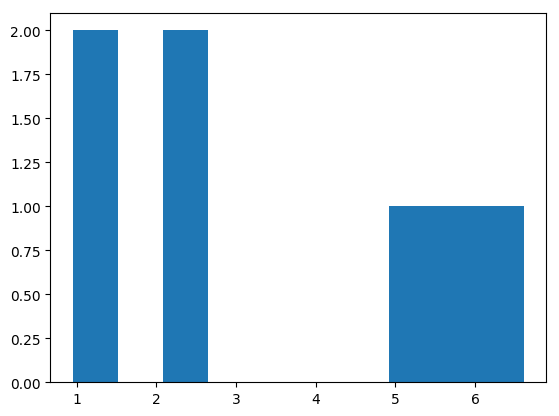

([2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0], [0.954344, 1.5201, 2.08585, 2.65161, 3.21736, 3.78312, 4.34887, 4.91463, 5.48038, 6.04614, 6.61189], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8ce5c0>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8ce3c8>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8ce908>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8cec50>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8cef98>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8db358>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8db6d8>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8dba58>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8dbdd8>, PyObject <matplotlib.patches.Rectangle object at 0x7ff2ea8e2198>])

In [4]:
data = df_henry[Symbol("CO2_henry coefficient [mmol/(g-bar)]")]
plt[:hist](data)

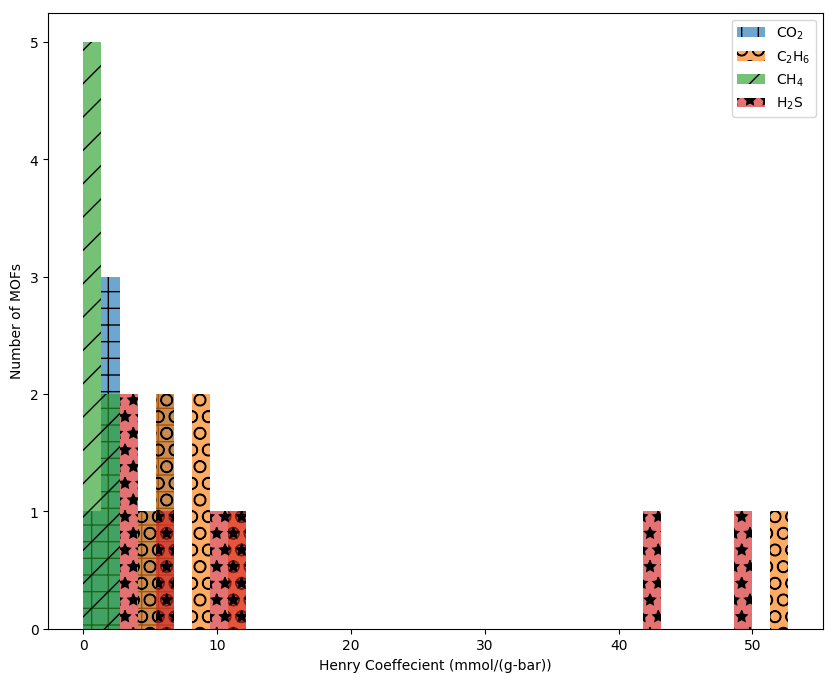

Float64

PyObject Text(0.5,1,'')

In [5]:
function plot_histogram()
    fig = figure(figsize=(10,8))
    gases = ["CO2", "C2H6", "CH4", "H2S"]
    gas_labels = [L"CO$_2$", L"C$_2$H$_6$", L"CH$_4$", L"H$_2$S"]
    gas_textures = ["+", "O", "/", "*"]
    bin_size = 1.35
    maximum_value = maximum([maximum(df_henry[Symbol(gases[i] * "_henry coefficient [mmol/(g-bar)]")]) for i = 1:length(gases)])
    print(typeof(maximum_value))
    for (i, gas) in enumerate(gases)
        plt[:hist](df_henry[Symbol(gas * "_henry coefficient [mmol/(g-bar)]")], label=gas_labels[i],
            alpha=0.65, bins=range(0, stop=maximum_value + bin_size, step=bin_size), hatch=gas_textures[i])
    end
    legend()
    # grid()
    xlabel("Henry Coeffecient (mmol/(g-bar))")
    ylabel("Number of MOFs")
    title("")
    
end
plot_histogram()

In [32]:
function perform_svd(gas1::AbstractString, gas2::AbstractString)
    #Should we create the program for comparing just two MOFs?
    #Or should it be able to compare 3 as well?

    # MOFs[1] indicates the length of the first column, eg. the number of MOFs being screened
    #initialize Henry's Matrix
    N = size(df_henry)[1]
    sigma = zeros(N, N, 2)

    for i = 1:N
        for j = i+1:N
            H = make_h_matrix3(i, j, gas1, gas2)
            F = svd(H)
            sigma[i, j, :] = F.S
        end
    end
    return sigma
end

perform_svd (generic function with 1 method)

In [7]:
function make_h_matrix(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof2, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof2, Symbol("CH4_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix (generic function with 1 method)

In [8]:
function make_h_matrix2(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix2 (generic function with 1 method)

In [33]:
function make_h_matrix3(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")] - df_henry[mof1, Symbol("p_xylene_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix3 (generic function with 1 method)

In [14]:
sigma = perform_svd("CO2","H2O_TIP5P")

7×7×2 Array{Float64,3}:
[:, :, 1] =
 0.0  189545.0  189545.0      189547.0    …  189545.0     189545.0   
 0.0       0.0       3.61361     879.938         31.1207      21.9558
 0.0       0.0       0.0         879.942         31.2668      22.1716
 0.0       0.0       0.0           0.0          880.464      880.194 
 0.0       0.0       0.0           0.0           31.1185      21.9517
 0.0       0.0       0.0           0.0    …       0.0         38.0698
 0.0       0.0       0.0           0.0            0.0          0.0   

[:, :, 2] =
 0.0  1.45413  2.21248   2.3916   0.954342   6.6111    5.70393 
 0.0  0.0      0.968995  1.45372  0.0304885  1.38853   1.36433 
 0.0  0.0      0.0       2.20529  0.677955   1.59364   1.43615 
 0.0  0.0      0.0       0.0      0.954167   6.52453   5.64466 
 0.0  0.0      0.0       0.0      0.0        0.919131  0.905088
 0.0  0.0      0.0       0.0      0.0        0.0       0.875072
 0.0  0.0      0.0       0.0      0.0        0.0       0.0     

In [15]:
function argmin_without_zero(matrix::Array{Float64, 2})
    index = CartesianIndex(1,1)
    lowest = Inf
    for i = 1:size(matrix)[1]
        for j = 1:size(matrix)[2]
            if matrix[i,j] < lowest && !isapprox(matrix[i,j], 0.0)
                lowest = matrix[i,j]
                index = CartesianIndex(i,j)
            end
        end
    end
    return index, lowest
end
    

argmin_without_zero (generic function with 1 method)

In [16]:
idx, lowest = argmin_without_zero(sigma[:,:,1])

(CartesianIndex(2, 5), 1.746817428564685)

In [17]:
function analyze_svd(sigma::Array{Float64, 3})

    #initialize some arrays
    best_indices = argmax(sigma[:, :, 2]) # finds the largest σ₂ value
    #TODO Needs fixing. worst_indices doesn't work
    worst_indices = argmin_without_zero(sigma[:, :, 1])[1] # finds the smallest σ₁ value

    MOF1 = String(df_henry[best_indices[1], :crystal])
    MOF2 = String(df_henry[best_indices[2], :crystal])

    println("The most sensitive pair of MOFs is " * MOF1 * " and " * MOF2)

    MOF3 = String(df_henry[worst_indices[1], :crystal])
    MOF4 = String(df_henry[worst_indices[2], :crystal])

    println("The least sensitive pair of MOFs is " * MOF3 * " and " * MOF4)

    #error analysis?
    #Delta K/H?

#=
    #create circle array
    n = 1000
    #TODO change to range
    x_lin = linspace(-1,1,n)
    y = zeros(2*n)
    x = zeros(2*n)
    for i = 1:n
        y[2 * i] = sqrt(1 - (x_lin[i] ^ 2))
        y[2 * i - 1] = - sqrt(1 - (x_lin[i] ^ 2))
        x[2 * i] = x_lin[i]
        x[2 * i - 1] = x_lin[i]
    end

    xx = x
    yy = y

    pre_plot = plot(x = xx, y = yy, Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    #formats the xy coords appropriately
    xy = hcat(x, y)
    xy = transpose(xy)

    #stretches the xy coords by the sigma from the svd
    highest_sigma = sigma[highest_index[1], highest_index[2]]
    sigma = [highest_sigma[1] 0; 0 highest_sigma[2]]
    println(sigma)
    xy_stretched = sigma*xy

    post_plot = plot(x = xy_stretched[1,:], y = xy_stretched[2,:], Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    return post_plot
    =#
end

analyze_svd (generic function with 1 method)

In [18]:
function mof2index(mof::AbstractString)
    boolarray = mof .== df_henry[:crystal]
    if sum(boolarray) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(boolarray) == 0
        @error "No MOF matched the given MOF name"
    end
    return argmax(boolarray)
end

mof2index (generic function with 1 method)

In [16]:
@testset "MOF to index test" begin
    @test isapprox(mof2index("COF-103"), 4)
end

┌ Error: No MOF matched the given MOF name
└ @ Main In[15]:6


MOF to index test: Test Failed at In[16]:2
  Expression: isapprox(mof2index("COF-103"), 4)
   Evaluated: isapprox(1, 4)
Stacktrace:
 [1] macro expansion at .\In[16]:2 [inlined]
 [2] macro expansion at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.0\Test\src\Test.jl:1083 [inlined]
 [3] top-level scope at .\In[16]:2
Test Summary:     | Fail  Total
MOF to index test |    1      1


TestSetException: Some tests did not pass: 0 passed, 1 failed, 0 errored, 0 broken.

In [26]:
function plot_response(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = make_h_matrix(mof1, mof2, gas1, gas2)
    F = svd(H)
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    n = H * p # required input

    S = perform_svd(gas1, gas2)
    biggest_σ = maximum(S[:, :, 1])

    function plot_vector(x; head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:hsv])
    m[:set_array]([]) # trick


    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    for k = 1:2
        plot_vector(F.V[:, k], color="k",
            label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    end
    title("Composition Space")
    tight_layout()

    subplot(122, aspect="equal")
    ylim([-biggest_σ, biggest_σ])
    xlim([-biggest_σ, biggest_σ])
    for i = 1:length(θ)-1
        plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k], head_length=0.005,
            head_width=0.05/3, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.025)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof1))
    ylabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof2))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mof1, mof2), format="png", dpi=300)
end

plot_response(mof1::AbstractString, mof2::AbstractString, gas1::AbstractString, gas2::AbstractString) = plot_response(mof2index(mof1), mof2index(mof2), gas1, gas2)

plot_response (generic function with 2 methods)

In [34]:
function plot_all_responses(gas1::AbstractString, gas2::AbstractString, index_list::Union{Array{Int64, 1}, Missing}=missing; 
                            print_h_matrix::Bool=false, add_legend::Bool=false, color_by_sigma::Int64=2)
    
    if color_by_sigma > 2 || color_by_sigma < 1
        error("`color_by_sigma` has to be 1 or 2")
    end
    S = perform_svd(gas1, gas2)
    biggest_σ₂ = maximum(S[:, :, 2])
    
    
    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    #for k = 1:2
    #    plot_vector(F.V[:, k], color="r",
    #        label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    #end
    title("Composition Space")
    
    if index_list !== missing
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end
    
#    cols = distinguishable_colors(size(collect(pairs))[1]+3, [RGB(1,1,1)])[4:end]
    ax = subplot(122)
    axis("equal")

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=biggest_σ₂)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:rainbow])
    m[:set_array]([]) # trick

    
    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        #@printf("Plotting %s and %s\n", mof1, mof2)
        H = make_h_matrix3(pair[1], pair[2], gas1, gas2)
        #if k == 1
        #    H = [-10 30; 72 9]
        #end
        if print_h_matrix
            println(pair)
            println(H)
        end
        F = svd(H)
        v1 = F.U[:,1] * F.S[1]
        if abs(v1[1]) > abs(v1[2])
            temp = H[1,:]
            H[1,:] = H[2,:]
            H[2,:] = [temp...]
        end
        θ_response = collect(range(0, stop=2*π, length=250))#[1:end - 1]
        θ_response[1] = deepcopy(θ_response[end])
        p_response = transpose(hcat(cos.(θ_response), sin.(θ_response))) # set pt change
        n = H * p_response # required input
        #for i = 1:length(θ_response) - 1
        #    plot(n[1, i:i+1], n[2, i:i+1], alpha=0.75, lw=3, c="#" * string(hex(cols[k])))#, label = label)
        #end
        plot(n[1,:], n[2, :], label=@sprintf("%s - %s",df_henry[pair[1], :crystal], df_henry[pair[2], :crystal]), 
            c=m[:to_rgba](F.S[color_by_sigma]))
    end
    if add_legend
        legend()
    end
    title(@sprintf("Response Space"))
    xlabel(@sprintf("\$n_1\$ (mmol/g)"))
    ylabel(@sprintf("\$n_2\$ (mmol/g)"))
    colorbar(m)

end

plot_all_responses(gas1::AbstractString, gas2::AbstractString, mof_list::Array{String, 1}) = plot_all_responses(gas1, gas2, mof2index.(mof_list))

plot_all_responses (generic function with 3 methods)

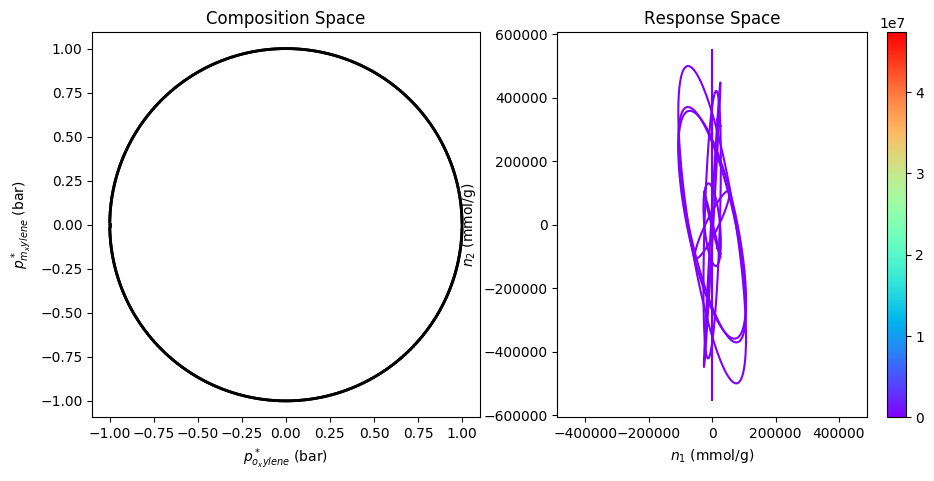

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff2b85725c0>

In [47]:
plot_all_responses("o_xylene", "m_xylene", [1,2,4,5,7])

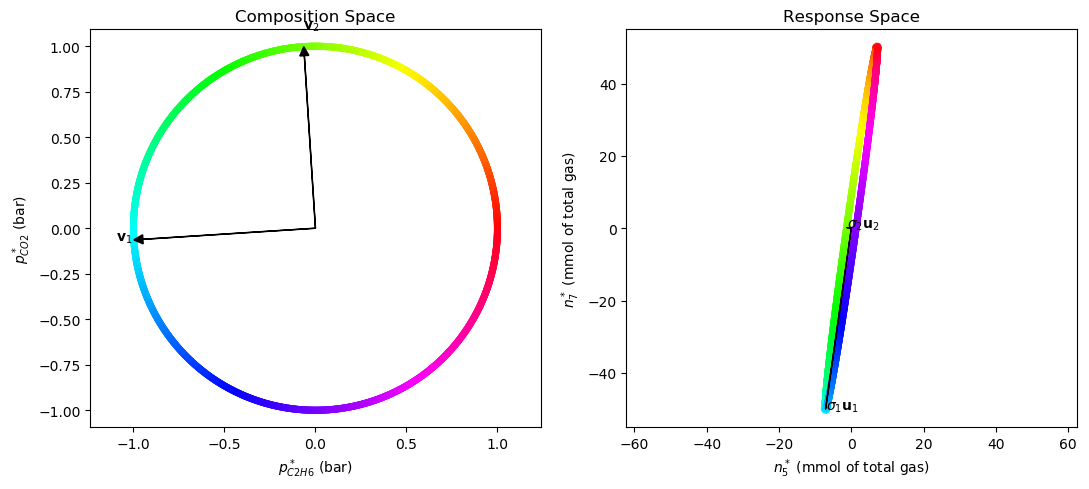

In [20]:
plot_response("NIBBOR", "RUBTAK01", "C2H6", "CO2")

In [18]:
sigma = perform_svd("C2H6", "CO2")
analyze_svd(sigma)

The most sensitive pair of MOFs is NIBBOR and REWNEO
The least sensitive pair of MOFs is BEDYEQ and KAMZUV


In [19]:
#@testset "Sensor Tests" begin
#    H = make_h_matrix(3, 5, "CO2", "C2H6")
#    G = [(8.91e-5) (4.84e-5); (1.87e-5) (4.68e-5)] .- [5.84e-6; 9.56e-6]
#    @test isapprox(H, G)
#end